In [3]:
# Imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import sqrtm
from tqdm import tqdm

# Device setup 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cpu


In [20]:
# Load dataset
data_path = "./data/creditcard.csv"  
df = pd.read_csv(data_path)

#  Remove NaNs & unnecessary columns
df = df.dropna()
if "Time" in df.columns:
    df = df.drop(columns=["Time"])

# Scale Amount column
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df[["Amount"]])

# Split features & labels
X = df.drop("Class", axis=1).values
y = df["Class"].values

print("Data loaded:", X.shape)
print("Fraud cases:", sum(y))


Data loaded: (284807, 29)
Fraud cases: 492


In [33]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

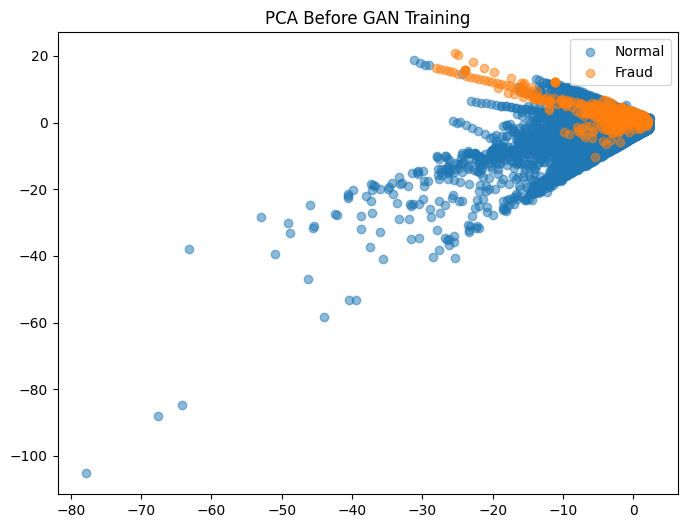

In [21]:
def plot_pca(X, y, title="PCA Visualization"):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[y==0, 0], reduced[y==0, 1], label="Normal", alpha=0.5)
    plt.scatter(reduced[y==1, 0], reduced[y==1, 1], label="Fraud", alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.show()

plot_pca(X, y, "PCA Before GAN Training")


In [22]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [23]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

def get_optimizers(generator, discriminator, lr_g=0.0002, lr_d=0.0002):
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    return opt_g, opt_d

def plot_gan_losses(g_losses, d_losses):
    plt.figure(figsize=(8,5))
    plt.plot(g_losses, label="Generator Loss")
    plt.plot(d_losses, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("GAN Loss Progression")
    plt.legend()
    plt.show()


In [24]:
from torch.utils.data import DataLoader, TensorDataset

def train_gan(generator, discriminator, dataloader, epochs, device, opt_g, opt_d, criterion):
    generator.train()
    discriminator.train()
    g_losses, d_losses = [], []

    for epoch in range(epochs):
        g_loss_epoch, d_loss_epoch = 0.0, 0.0
        for real_samples in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            real_samples = real_samples[0].to(device)
            batch_size = real_samples.size(0)

            # Train Discriminator
            opt_d.zero_grad()
            z = torch.randn(batch_size, generator.model[0].in_features, device=device)
            fake_samples = generator(z)
            real_labels = torch.ones((batch_size, 1), device=device)
            fake_labels = torch.zeros((batch_size, 1), device=device)

            real_loss = criterion(discriminator(real_samples), real_labels)
            fake_loss = criterion(discriminator(fake_samples.detach()), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            # Train Generator
            opt_g.zero_grad()
            gen_labels = torch.ones((batch_size, 1), device=device)
            g_loss = criterion(discriminator(fake_samples), gen_labels)
            g_loss.backward()
            opt_g.step()

            g_loss_epoch += g_loss.item() * batch_size
            d_loss_epoch += d_loss.item() * batch_size

        g_losses.append(g_loss_epoch / len(dataloader.dataset))
        d_losses.append(d_loss_epoch / len(dataloader.dataset))
        print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_losses[-1]:.4f}  G_loss: {g_losses[-1]:.4f}")

    plot_gan_losses(g_losses, d_losses)
    return generator, discriminator, g_losses, d_losses


In [25]:
def calculate_fid(real_samples, fake_samples):
    try:
        mu1, sigma1 = np.mean(real_samples, axis=0), np.cov(real_samples, rowvar=False)
        mu2, sigma2 = np.mean(fake_samples, axis=0), np.cov(fake_samples, rowvar=False)
        diff = mu1 - mu2
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
        return np.real(fid)
    except Exception as e:
        print(f"[Warning] FID calculation failed ({e}). Using cosine similarity fallback.")
        sim = cosine_similarity(real_samples, fake_samples).mean()
        return 1 - sim  # lower = better


Starting GAN training...


Epoch [1/100]  D_loss: 2.8760  G_loss: 1.1500


Epoch [2/100]  D_loss: 2.5837  G_loss: 1.0594


Epoch [3/100]  D_loss: 2.0577  G_loss: 0.9933


Epoch [4/100]  D_loss: 1.9526  G_loss: 0.9938


Epoch [5/100]  D_loss: 1.6883  G_loss: 0.9686


Epoch [6/100]  D_loss: 1.3891  G_loss: 0.9443


Epoch [7/100]  D_loss: 1.2498  G_loss: 0.9007


Epoch [8/100]  D_loss: 1.0477  G_loss: 0.8621


Epoch [9/100]  D_loss: 0.9129  G_loss: 0.8426


Epoch [10/100]  D_loss: 0.9292  G_loss: 0.8190


Epoch [11/100]  D_loss: 0.8268  G_loss: 0.8043


Epoch [12/100]  D_loss: 0.7509  G_loss: 0.7988


Epoch [13/100]  D_loss: 0.6961  G_loss: 0.7843


Epoch [14/100]  D_loss: 0.6424  G_loss: 0.7536


Epoch [15/100]  D_loss: 0.6584  G_loss: 0.7591


Epoch [16/100]  D_loss: 0.6326  G_loss: 0.7417


Epoch [17/100]  D_loss: 0.6344  G_loss: 0.7673


Epoch [18/100]  D_loss: 0.6557  G_loss: 0.7197


Epoch [19/100]  D_loss: 0.5928  G_loss: 0.7102


Epoch [20/100]  D_loss: 0.6251  G_loss: 0.7077


Epoch [21/100]  D_loss: 0.5967  G_loss: 0.7185


Epoch [22/100]  D_loss: 0.5945  G_loss: 0.7031


Epoch [23/100]  D_loss: 0.5849  G_loss: 0.7022


Epoch [24/100]  D_loss: 0.5743  G_loss: 0.6805


Epoch [25/100]  D_loss: 0.5832  G_loss: 0.6909


Epoch [26/100]  D_loss: 0.5640  G_loss: 0.6834


Epoch [27/100]  D_loss: 0.6043  G_loss: 0.6792


Epoch [28/100]  D_loss: 0.5661  G_loss: 0.6576


Epoch [29/100]  D_loss: 0.5708  G_loss: 0.6677


Epoch [30/100]  D_loss: 0.5579  G_loss: 0.6654


Epoch [31/100]  D_loss: 0.5584  G_loss: 0.6737


Epoch [32/100]  D_loss: 0.5611  G_loss: 0.6600


Epoch [33/100]  D_loss: 0.5735  G_loss: 0.6494


Epoch [34/100]  D_loss: 0.5905  G_loss: 0.6696


Epoch [35/100]  D_loss: 0.5911  G_loss: 0.6590


Epoch [36/100]  D_loss: 0.5877  G_loss: 0.6377


Epoch [37/100]  D_loss: 0.5658  G_loss: 0.6594


Epoch [38/100]  D_loss: 0.5884  G_loss: 0.6419


Epoch [39/100]  D_loss: 0.5546  G_loss: 0.6448


Epoch [40/100]  D_loss: 0.5751  G_loss: 0.6455


Epoch [41/100]  D_loss: 0.5832  G_loss: 0.6318


Epoch [42/100]  D_loss: 0.5779  G_loss: 0.6416


Epoch [43/100]  D_loss: 0.5625  G_loss: 0.6397


Epoch [44/100]  D_loss: 0.5835  G_loss: 0.6446


Epoch [45/100]  D_loss: 0.5662  G_loss: 0.6490


Epoch [46/100]  D_loss: 0.5697  G_loss: 0.6190


Epoch [47/100]  D_loss: 0.5711  G_loss: 0.6441


Epoch [48/100]  D_loss: 0.5730  G_loss: 0.6359


Epoch [49/100]  D_loss: 0.5673  G_loss: 0.6415


Epoch [50/100]  D_loss: 0.5781  G_loss: 0.6461


Epoch [51/100]  D_loss: 0.5555  G_loss: 0.6261


Epoch [52/100]  D_loss: 0.5619  G_loss: 0.6295


Epoch [53/100]  D_loss: 0.5862  G_loss: 0.6125


Epoch [54/100]  D_loss: 0.5710  G_loss: 0.6319


Epoch [55/100]  D_loss: 0.5686  G_loss: 0.6194


Epoch [56/100]  D_loss: 0.5761  G_loss: 0.6282


Epoch [57/100]  D_loss: 0.5793  G_loss: 0.6298


Epoch [58/100]  D_loss: 0.6135  G_loss: 0.6248


Epoch [59/100]  D_loss: 0.5717  G_loss: 0.6170


Epoch [60/100]  D_loss: 0.5814  G_loss: 0.6259


Epoch [61/100]  D_loss: 0.5801  G_loss: 0.6184


Epoch [62/100]  D_loss: 0.5730  G_loss: 0.6194


Epoch [63/100]  D_loss: 0.6136  G_loss: 0.6154


Epoch [64/100]  D_loss: 0.5677  G_loss: 0.6111


Epoch [65/100]  D_loss: 0.5972  G_loss: 0.6327


Epoch [66/100]  D_loss: 0.6021  G_loss: 0.6145


Epoch [67/100]  D_loss: 0.6083  G_loss: 0.6296


Epoch [68/100]  D_loss: 0.5867  G_loss: 0.6092


Epoch [69/100]  D_loss: 0.6091  G_loss: 0.6074


Epoch [70/100]  D_loss: 0.6353  G_loss: 0.6009


Epoch [71/100]  D_loss: 0.6031  G_loss: 0.5835


Epoch [72/100]  D_loss: 0.6070  G_loss: 0.5908


Epoch [73/100]  D_loss: 0.6145  G_loss: 0.6008


Epoch [74/100]  D_loss: 0.6136  G_loss: 0.6075


Epoch [75/100]  D_loss: 0.5765  G_loss: 0.5992


Epoch [76/100]  D_loss: 0.6065  G_loss: 0.6047


Epoch [77/100]  D_loss: 0.5815  G_loss: 0.6171


Epoch [78/100]  D_loss: 0.6236  G_loss: 0.5880


Epoch [79/100]  D_loss: 0.6035  G_loss: 0.5999


Epoch [80/100]  D_loss: 0.6167  G_loss: 0.6073


Epoch [81/100]  D_loss: 0.6140  G_loss: 0.6098


Epoch [82/100]  D_loss: 0.5929  G_loss: 0.6118


Epoch [83/100]  D_loss: 0.6253  G_loss: 0.6128


Epoch [84/100]  D_loss: 0.5943  G_loss: 0.6073


Epoch [85/100]  D_loss: 0.6071  G_loss: 0.6084


Epoch [86/100]  D_loss: 0.6289  G_loss: 0.6257


Epoch [87/100]  D_loss: 0.6251  G_loss: 0.6150


Epoch [88/100]  D_loss: 0.6010  G_loss: 0.6204


Epoch [89/100]  D_loss: 0.6172  G_loss: 0.6228


Epoch [90/100]  D_loss: 0.6055  G_loss: 0.6233


Epoch [91/100]  D_loss: 0.6075  G_loss: 0.6255


Epoch [92/100]  D_loss: 0.5768  G_loss: 0.6282


Epoch [93/100]  D_loss: 0.5871  G_loss: 0.6456


Epoch [94/100]  D_loss: 0.5800  G_loss: 0.6148


Epoch [95/100]  D_loss: 0.6066  G_loss: 0.6432


Epoch [96/100]  D_loss: 0.6143  G_loss: 0.6426


Epoch [97/100]  D_loss: 0.6097  G_loss: 0.6270


Epoch [98/100]  D_loss: 0.6024  G_loss: 0.6437


Epoch [99/100]  D_loss: 0.5950  G_loss: 0.6544


Epoch [100/100]  D_loss: 0.5982  G_loss: 0.6335


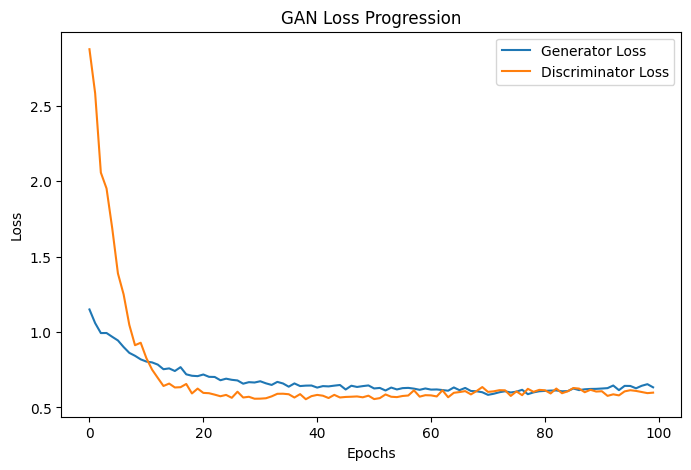

Generating synthetic fraud samples...


In [26]:
# Config 
LATENT_DIM = 32
HIDDEN_DIM = 64
BATCH_SIZE = 128
EPOCHS = 100
LR_G = 0.0002
LR_D = 0.0002

# Prepare fraud-only data
X_fraud = X[y == 1]
tensor_data = torch.tensor(X_fraud, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(tensor_data), batch_size=BATCH_SIZE, shuffle=True)

# Initialize models
feature_dim = X.shape[1]
generator = Generator(LATENT_DIM, feature_dim, HIDDEN_DIM).to(DEVICE)
discriminator = Discriminator(feature_dim, HIDDEN_DIM).to(DEVICE)
generator.apply(weights_init)
discriminator.apply(weights_init)

# Optimizers and loss
opt_g, opt_d = get_optimizers(generator, discriminator, LR_G, LR_D)
criterion = nn.BCELoss()

# Train GAN
print("Starting GAN training...")
generator, discriminator, g_losses, d_losses = train_gan(generator, discriminator, dataloader, EPOCHS, DEVICE, opt_g, opt_d, criterion)

#  Generate synthetic data
def generate_synthetic_data(generator, num_samples, latent_dim, device):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        synthetic_data = generator(z).cpu().numpy()
    return synthetic_data

print("Generating synthetic fraud samples...")
synthetic_data = generate_synthetic_data(generator, len(X_fraud), LATENT_DIM, DEVICE)


Similarity score (lower is better): 563.4924


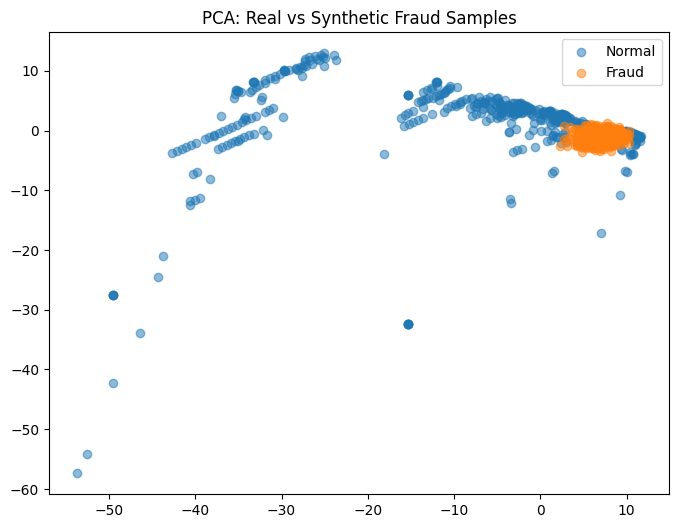

GAN training and evaluation complete!


In [27]:
# Evaluate similarity 
fid_score = calculate_fid(X_fraud, synthetic_data)
print(f"Similarity score (lower is better): {fid_score:.4f}")

# PCA Visualization of real vs synthetic 
combined_X = np.vstack((X_fraud[:len(synthetic_data)], synthetic_data))
combined_y = np.hstack((np.zeros(len(X_fraud[:len(synthetic_data)])), np.ones(len(synthetic_data))))
plot_pca(combined_X, combined_y, "PCA: Real vs Synthetic Fraud Samples")

print("GAN training and evaluation complete!")


In [28]:
from sklearn.model_selection import train_test_split

# Combine synthetic fraud samples with real data 
X_augmented = np.vstack((X, synthetic_data))
y_augmented = np.hstack((y, np.ones(len(synthetic_data))))  # label synthetic fraud as fraud (1)

print(f"Original dataset: {X.shape}, Fraud cases: {sum(y)}")
print(f"Augmented dataset: {X_augmented.shape}, Fraud cases: {sum(y_augmented)}")

#Split into train/val/test 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train_aug, X_temp_aug, y_train_aug, y_temp_aug = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42, stratify=y_augmented)
X_val_aug, X_test_aug, y_val_aug, y_test_aug = train_test_split(X_temp_aug, y_temp_aug, test_size=0.5, random_state=42, stratify=y_temp_aug)

print(f"Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")


Original dataset: (284807, 29), Fraud cases: 492
Augmented dataset: (285299, 29), Fraud cases: 984.0
Train: 199364, Val: 42721, Test: 42722


In [29]:
from sklearn.linear_model import LogisticRegression

def train_classifier(X_train, y_train, X_val, y_val):
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X_train, y_train)
    val_pred = clf.predict(X_val)
    return clf, val_pred

print("Training classifier on original data...")
clf_orig, val_pred_orig = train_classifier(X_train, y_train, X_val, y_val)

print("Training classifier on augmented data...")
clf_aug, val_pred_aug = train_classifier(X_train_aug, y_train_aug, X_val_aug, y_val_aug)


Training classifier on original data...
Training classifier on augmented data...



 Original Model Performance:
Accuracy : 0.9781
Precision: 0.0655
Recall   : 0.8784
F1 Score : 0.1220
ROC-AUC  : 0.9693
--------------------------------------------------

 Augmented (GAN) Model Performance:
Accuracy : 0.9863
Precision: 0.1967
Recall   : 0.9728
F1 Score : 0.3272
ROC-AUC  : 0.9906
--------------------------------------------------

 Original Performance:
Accuracy : 0.9781
Precision: 0.0655
Recall   : 0.8784
F1 Score : 0.1220
ROC-AUC  : 0.9693
--------------------------------------------------

 Augmented Performance:
Accuracy : 0.9863
Precision: 0.1967
Recall   : 0.9728
F1 Score : 0.3272
ROC-AUC  : 0.9906
--------------------------------------------------


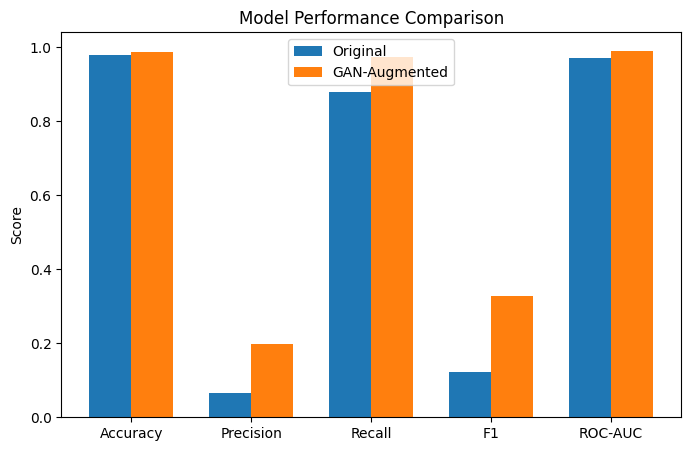

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

def evaluate_model(clf, X_test, y_test, label="Model"):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    print(f" {label} Performance:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print("-" * 50)
    return acc, prec, rec, f1, auc

# Evaluate on test sets 
evaluate_model(clf_orig, X_test, y_test, "Original Model")
evaluate_model(clf_aug, X_test_aug, y_test_aug, "Augmented (GAN) Model")

import matplotlib.pyplot as plt

labels = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
orig_scores = evaluate_model(clf_orig, X_test, y_test, "Original")[0:5]
aug_scores = evaluate_model(clf_aug, X_test_aug, y_test_aug, "Augmented")[0:5]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(8,5))
plt.bar(x - width/2, orig_scores, width, label="Original")
plt.bar(x + width/2, aug_scores, width, label="GAN-Augmented")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()



📈 Original (Real-Only) Model Performance:
Accuracy : 0.9777
Precision: 0.0640
Recall   : 0.8716
F1 Score : 0.1192
ROC-AUC  : 0.9699
--------------------------------------------------

📈 Augmented (Real + GAN) Model Performance:
Accuracy : 0.9863
Precision: 0.1947
Recall   : 0.9458
F1 Score : 0.3229
ROC-AUC  : 0.9828
--------------------------------------------------


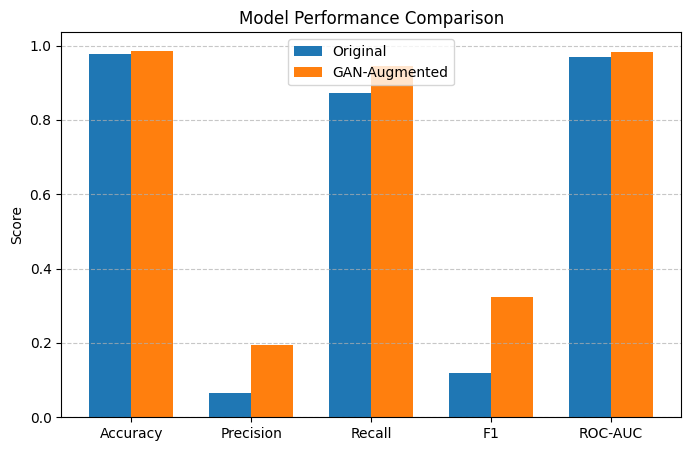

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Function to Evaluate a Model
def evaluate_model(clf, X_test, y_test, label="Model"):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    print(f"\n {label} Performance:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print("-" * 50)
    return acc, prec, rec, f1, auc

# Split the original (real-only) data for baseline
from sklearn.model_selection import train_test_split

X_real = X
y_real = y

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_real, y_real, test_size=0.3, random_state=42, stratify=y_real
)

#Train baseline classifier (only real data) 
clf_orig = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
clf_orig.fit(X_train_orig, y_train_orig)

# Train augmented classifier (real + synthetic fraud samples)
X_train_aug = X_augmented
y_train_aug = y_augmented

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_train_aug, y_train_aug, test_size=0.3, random_state=42, stratify=y_train_aug
)

clf_aug = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
clf_aug.fit(X_train_aug, y_train_aug)

# Evaluate both models
orig_scores = evaluate_model(clf_orig, X_test_orig, y_test_orig, "Original (Real-Only) Model")
aug_scores = evaluate_model(clf_aug, X_test_aug, y_test_aug, "Augmented (Real + GAN) Model")

# Compare visually 
labels = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, orig_scores, width, label="Original")
plt.bar(x + width/2, aug_scores, width, label="GAN-Augmented")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [32]:
import json, os
os.makedirs("./results", exist_ok=True)

metrics = {
    "original": dict(zip(["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"], orig_scores)),
    "augmented": dict(zip(["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"], aug_scores))
}

with open("./results/metrics_report.txt", "w") as f:
    json.dump(metrics, f, indent=4)

print("✅ Metrics saved to results/metrics_report.txt")


✅ Metrics saved to results/metrics_report.txt


ImportError: cannot import name 'Generator' from 'models' (unknown location)

In [7]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.8.0+cpu
CUDA available: False


In [11]:
# ===================================================
# DEMO SECTION: Load Trained GAN and Generate Samples
# ===================================================

import torch
import pandas as pd
import sys, os

# Ensure notebook can see your project folders
sys.path.append(os.path.abspath('./'))

# Import your Generator model from models/generator.py
from models.generator import Generator

LATENT_DIM = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1️⃣ Rebuild the model architecture
generator = Generator(LATENT_DIM).to(DEVICE)

# 2️⃣ Load your trained weights
generator.load_state_dict(torch.load("models/generator.pth", map_location=DEVICE))
generator.eval()

print("✅ Trained Generator loaded successfully!")


TypeError: Generator.__init__() missing 1 required positional argument: 'output_dim'

In [13]:
# After GAN training loop finishes:
torch.save(generator.state_dict(), "models/generator.pth")
torch.save(discriminator.state_dict(), "models/discriminator.pth")

print("✅ Models saved successfully in /models folder.")


NameError: name 'generator' is not defined